Implemente los algoritmos de clasificación (RNN y LSTM) para el análisis de sentimiento.

In [31]:
import pandas as pd
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np

In [3]:
pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00


In [5]:
df = pd.read_csv('/content/dataset.tsv', sep='\t', header=None)
df.columns = ["Sentiment", "Comment"]
df.head()

,Sentiment,Comment
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...
1,neg,"adha drama to censor hi hojaye gaa , khaas to..."
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...
3,neg,choor kasuri choor jhootay ka moo kaala
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...


## Modelo LSTM

In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN
from tensorflow.keras.optimizers import Adam
import os
from joblib import dump, load

In [55]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [63]:
X = df['Comment']
Y = pd.get_dummies(df['Sentiment']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [64]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

In [67]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(64))  # Capa LSTM con 64 unidades
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
history_lstm = None
if os.path.exists('history_lstm.joblib'):
    history_lstm = load('history_lstm.joblib')
    print("El archivo 'history_lstm.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history = model.fit(X_train_seq, Y_train, epochs=30, batch_size=32, verbose=2)
    dump(history.history, 'history_lstm.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_lstm.joblib'.")

Epoch 1/30
293/293 - 24s - 81ms/step - accuracy: 0.9161 - loss: 0.2188
Epoch 2/30
293/293 - 43s - 147ms/step - accuracy: 0.9418 - loss: 0.1602
Epoch 3/30
293/293 - 23s - 79ms/step - accuracy: 0.9590 - loss: 0.1166
Epoch 4/30
293/293 - 40s - 136ms/step - accuracy: 0.9682 - loss: 0.0893
Epoch 5/30
293/293 - 45s - 153ms/step - accuracy: 0.9773 - loss: 0.0658
Epoch 6/30
293/293 - 35s - 118ms/step - accuracy: 0.9842 - loss: 0.0487
Epoch 7/30
293/293 - 22s - 75ms/step - accuracy: 0.9827 - loss: 0.0497
Epoch 8/30
293/293 - 41s - 139ms/step - accuracy: 0.9872 - loss: 0.0377
Epoch 9/30
293/293 - 41s - 139ms/step - accuracy: 0.9886 - loss: 0.0342
Epoch 10/30
293/293 - 40s - 137ms/step - accuracy: 0.9899 - loss: 0.0295
Epoch 11/30
293/293 - 32s - 111ms/step - accuracy: 0.9911 - loss: 0.0245
Epoch 12/30
293/293 - 36s - 123ms/step - accuracy: 0.9925 - loss: 0.0208
Epoch 13/30
293/293 - 44s - 152ms/step - accuracy: 0.9942 - loss: 0.0158
Epoch 14/30
293/293 - 36s - 122ms/step - accuracy: 0.9939 - los

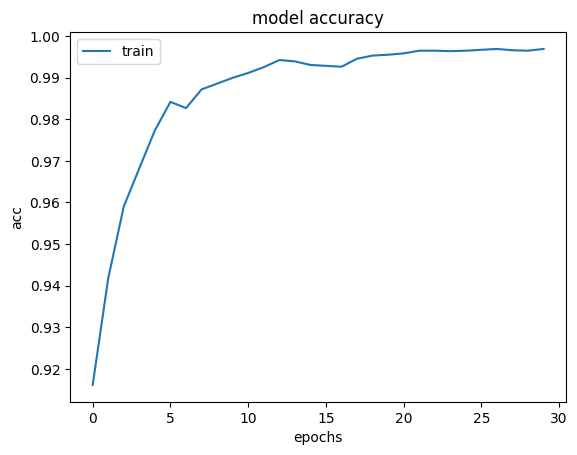

In [73]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left');

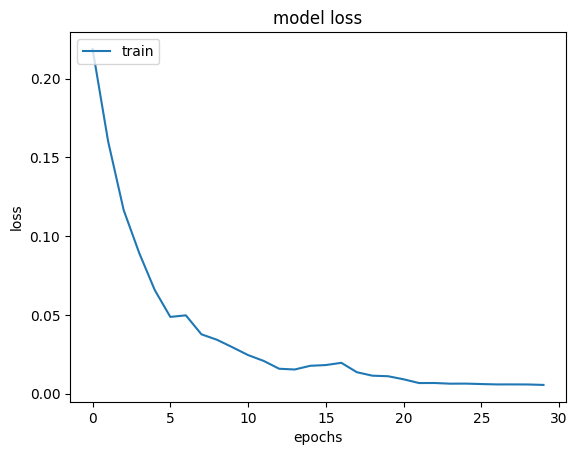

In [74]:
plt.plot(history.history['loss']);
plt.title('model loss');
plt.ylabel('loss');
plt.xlabel('epochs');
plt.legend(['train', 'test'], loc='upper left');

In [78]:
_, train_acc = model.evaluate(X_train_seq, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test_seq, Y_test, verbose=2)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

293/293 - 6s - 21ms/step - accuracy: 0.9975 - loss: 0.0048
52/52 - 1s - 22ms/step - accuracy: 0.7752 - loss: 2.2862
Train: 0.998, Test: 0.775
Train: 0.998, Test: 0.7752


In [79]:
yhat_probs = model.predict(X_test_seq, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)

In [80]:
rounded_labels=np.argmax(Y_test, axis=1)

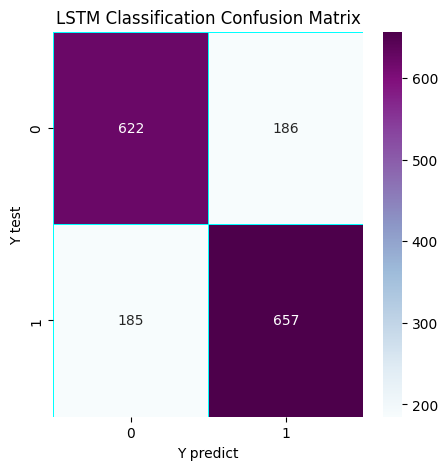

In [81]:
from sklearn.metrics import confusion_matrix

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

## Modelo RNN

In [84]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_RNN.add(SimpleRNN(64))
model_RNN.add(Dense(Y.shape[1], activation='softmax'))
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
history_RNN = None
if os.path.exists('history_RNN.joblib'):
    history_RNN = load('history_RNN.joblib')
    print("El archivo 'history_RNN.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history_RNN = model_RNN.fit(X_train_seq, Y_train, epochs=30, batch_size=32, verbose=2)
    dump(history.history, 'history_RNN.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_RNN.joblib'.")

Epoch 1/30
293/293 - 12s - 41ms/step - accuracy: 0.6606 - loss: 0.6036
Epoch 2/30
293/293 - 9s - 31ms/step - accuracy: 0.8547 - loss: 0.3467
Epoch 3/30
293/293 - 12s - 41ms/step - accuracy: 0.9580 - loss: 0.1254
Epoch 4/30
293/293 - 11s - 36ms/step - accuracy: 0.9877 - loss: 0.0459
Epoch 5/30
293/293 - 18s - 63ms/step - accuracy: 0.9936 - loss: 0.0264
Epoch 6/30
293/293 - 11s - 36ms/step - accuracy: 0.9952 - loss: 0.0182
Epoch 7/30
293/293 - 11s - 36ms/step - accuracy: 0.9960 - loss: 0.0164
Epoch 8/30
293/293 - 21s - 71ms/step - accuracy: 0.9960 - loss: 0.0157
Epoch 9/30
293/293 - 20s - 69ms/step - accuracy: 0.9954 - loss: 0.0167
Epoch 10/30
293/293 - 20s - 67ms/step - accuracy: 0.9955 - loss: 0.0160
Epoch 11/30
293/293 - 11s - 38ms/step - accuracy: 0.9921 - loss: 0.0260
Epoch 12/30
293/293 - 11s - 36ms/step - accuracy: 0.9918 - loss: 0.0255
Epoch 13/30
293/293 - 20s - 70ms/step - accuracy: 0.9909 - loss: 0.0258
Epoch 14/30
293/293 - 20s - 70ms/step - accuracy: 0.9940 - loss: 0.0174
Ep

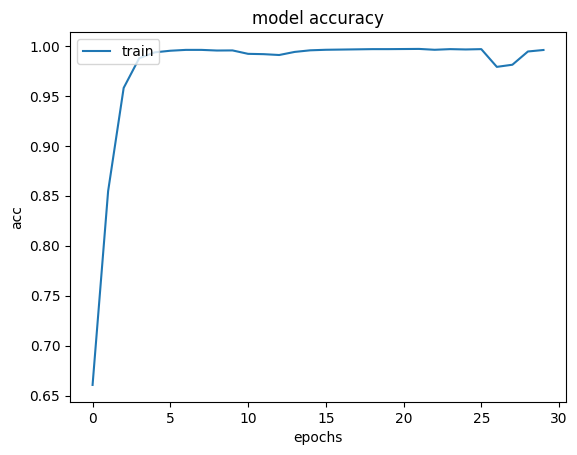

In [87]:
plt.plot(history_RNN.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left');

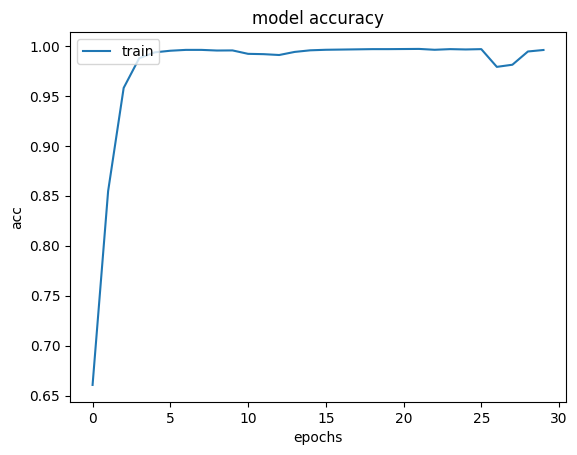

In [88]:
plt.plot(history_RNN.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left');

In [89]:
_, train_acc = model_RNN.evaluate(X_train_seq, Y_train, verbose=2)
_, test_acc = model_RNN.evaluate(X_test_seq, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

293/293 - 2s - 8ms/step - accuracy: 0.9973 - loss: 0.0060
52/52 - 0s - 8ms/step - accuracy: 0.6958 - loss: 1.6036
Train: 0.997, Test: 0.6958


In [91]:
yhat_probs = model_RNN.predict(X_test_seq, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)

In [92]:
rounded_labels=np.argmax(Y_test, axis=1)

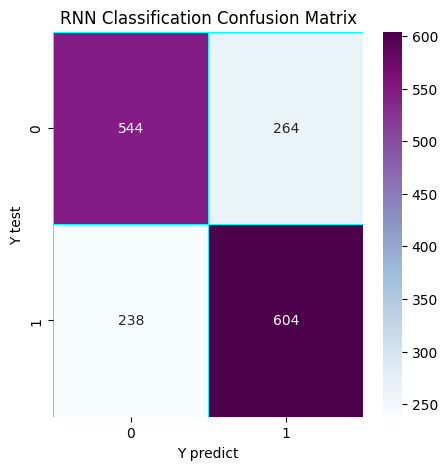

In [93]:
RNN_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(RNN_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('RNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()